In [1]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Model
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pathlib
num_classes=38

In [2]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 33.84 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (182401/182401), done.


In [3]:
train_folder_path = '/content/PlantVillage-Dataset/raw/color'
# Get the list of class (species) folders
train_class_folders = glob(train_folder_path + '/*')

# Initialize lists to store images and labels
images = []
labels = []

# Load images and labels from subfolders
for class_folder in train_class_folders:
    label = (class_folder.split('/')[-1])  # Adjust the index based on your folder structure
    # Get the list of image file paths in the current class folder
    image_files = glob(class_folder + '/*.JPG')
    image_files2 = glob(class_folder + '/*.jpg')  # Update the extension based on your image format
    # Load and resize images
    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.resize(img, (128, 128))  # Adjust the size as needed
        images.append(img)
        labels.append(label)

    for image_file in image_files2:
        img = cv2.imread(image_file)
        img = cv2.resize(img, (128, 128))  # Adjust the size as needed
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Optionally, normalize pixel values to be in the range [0, 1]
images = images.astype('float32') / 255.0

# Print the shape of the data
print("x_train shape:", images.shape)
print("y_train shape:", labels.shape)

x_train shape: (54303, 128, 128, 3)
y_train shape: (54303,)


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encoding
label_encoder = LabelEncoder()
labels1 = label_encoder.fit_transform(labels)

# One-hot encoding
labels = to_categorical(labels1,num_classes)

# Display the results
print("Integer Encoded Labels:", labels1)
print("One-Hot Encoded Labels:\n", labels)

Integer Encoded Labels: [29 29 29 ... 25 25 25]
One-Hot Encoded Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test=train_test_split(x_temp, y_temp, test_size=0.5,random_state=0)

In [6]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [7]:
def resnet_v2(input_shape, depth, num_classes=38):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (Dataset has 38)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer (inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=4)(x) #change made from 8 to 4
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
n=3
depth = n*9+2
model = resnet_v2(input_shape = images.shape[1:],depth=depth)
batch = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [11]:
trained_model2 = model.fit(x_train, y_train,
    epochs=50,
    batch_size=batch,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping])

Epoch 1/50
1188/1188 [==============================] - 121s 85ms/step - loss: 1.3442 - accuracy: 0.7667 - val_loss: 1.7586 - val_accuracy: 0.6971
Epoch 2/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.6478 - accuracy: 0.8979 - val_loss: 0.7097 - val_accuracy: 0.8675
Epoch 3/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.4588 - accuracy: 0.9292 - val_loss: 0.6051 - val_accuracy: 0.8810
Epoch 4/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.3588 - accuracy: 0.9468 - val_loss: 0.7862 - val_accuracy: 0.8331
Epoch 5/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.2962 - accuracy: 0.9580 - val_loss: 1.9944 - val_accuracy: 0.7295
Epoch 6/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.2539 - accuracy: 0.9642 - val_loss: 0.4656 - val_accuracy: 0.9037
Epoch 7/50
1188/1188 [==============================] - 96s 81ms/step - loss: 0.2256 - accuracy: 0.9680 - val_loss: 0.4446 

In [12]:
model.evaluate(x_test,y_test,verbose=1)

255/255 [==============================] - 6s 25ms/step - loss: 0.2582 - accuracy: 0.9503


[0.25818654894828796, 0.9502823352813721]

In [13]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)

255/255 [==============================] - 6s 21ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88        98
           1       0.96      1.00      0.98       107
           2       0.97      0.85      0.91        34
           3       0.98      0.87      0.92       252
           4       0.92      1.00      0.96       220
           5       0.99      0.98      0.98       166
           6       0.98      0.98      0.98       132
           7       0.86      0.72      0.78        75
           8       1.00      0.98      0.99       181
           9       0.89      0.88      0.88       166
          10       0.99      1.00      0.99       183
          11       0.96      0.98      0.97       175
          12       0.98      0.97      0.97       196
          13       0.99      1.00      0.99       157
          14       1.00      0.95      0.97        59
          15       0.98      1.00      0.99       831
 

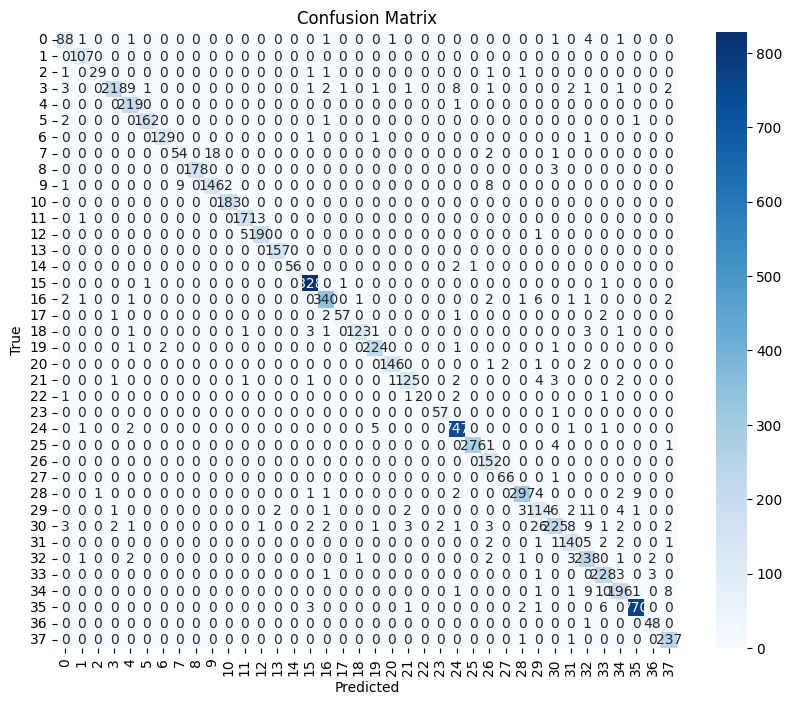

Confusion Matrix:
 [[ 88   1   0 ...   0   0   0]
 [  0 107   0 ...   0   0   0]
 [  1   0  29 ...   0   0   0]
 ...
 [  0   0   0 ... 770   0   0]
 [  0   0   0 ...   0  48   0]
 [  0   0   0 ...   0   0 237]]


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
classname=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classname, yticklabels=classname)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", conf_matrix)

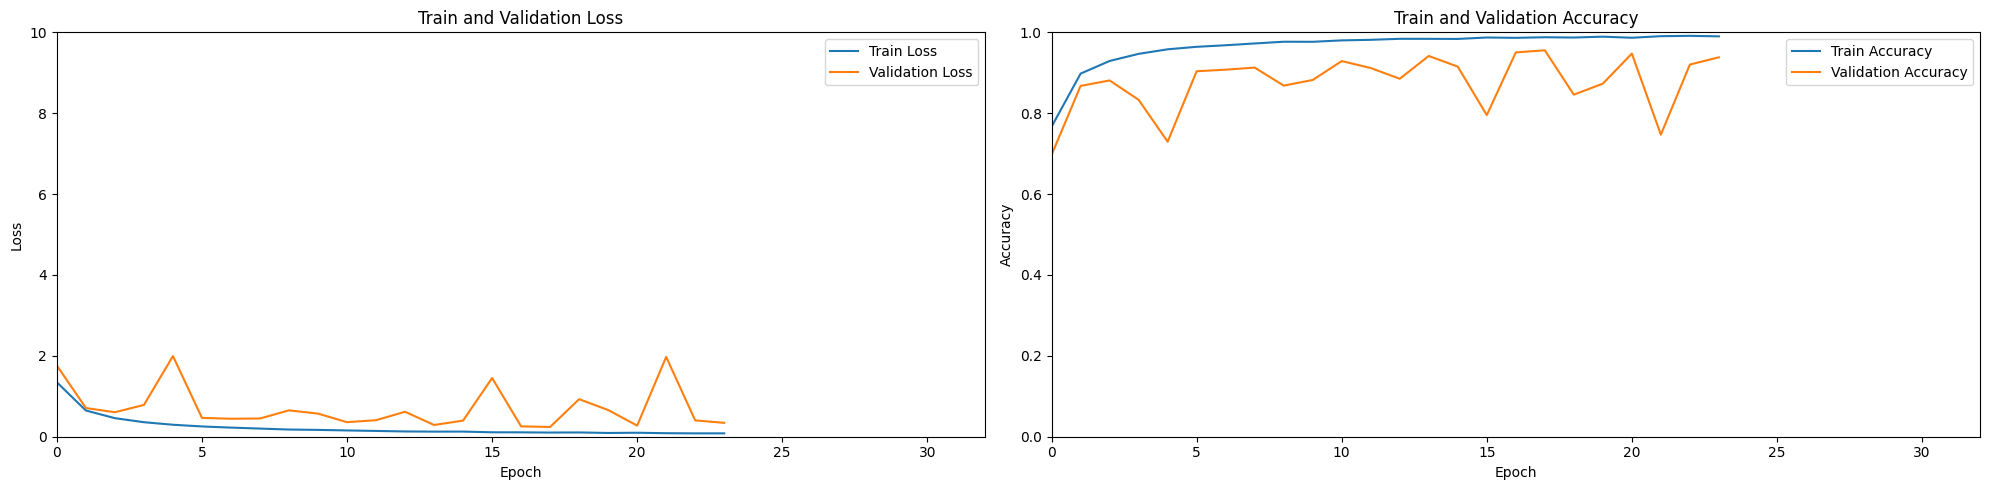

In [16]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(trained_model2.history['loss'],label="Train Loss")
plt.plot(trained_model2.history['val_loss'], label="Validation Loss")
plt.xlim(0,32)
plt.ylim(0,10)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(trained_model2.history['accuracy'], label="Train Accuracy")
plt.plot(trained_model2.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0,32)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 3: Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=" ", yticklabels=" ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.